In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['creditcard.csv']


In [2]:
df = pd.read_csv("../input/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


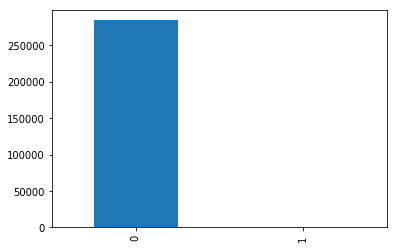

In [3]:
df['Class'].value_counts().plot(kind='bar')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

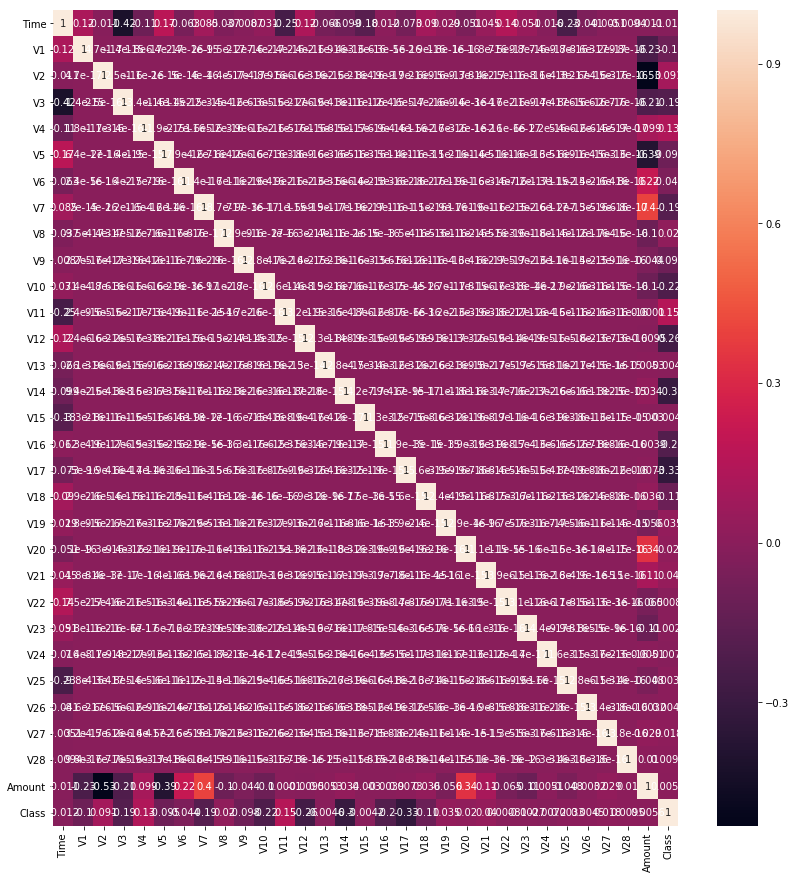

In [5]:
plt.figure(figsize=(14,15))
sns.heatmap(df.corr(),annot=True)

In [6]:
df['V7'].unique()

array([ 0.23959855, -0.07880298,  0.79146096, ..., -0.29682653,
       -0.68617999,  1.57700625])

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
sc = StandardScaler()
df['normAmount'] = sc.fit_transform(df.Amount.values.reshape(-1,1))

In [9]:
df.drop(['Time','Amount'],inplace=True,axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [10]:
X = df.loc[:,df.columns!='Class']
y = df.loc[:,'Class']
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [11]:
number_fraud = y.value_counts()[1]
fraud_samples = X[y==1]
fraud_samples_indices = fraud_samples.index.tolist()
number_non_fraud = y.value_counts()[0]
non_fraud_indices = X[y==0].index.tolist()
non_fraud_samples = np.random.choice(non_fraud_indices,number_fraud,replace=False)

In [12]:
under_sample_indices = np.hstack((fraud_samples_indices,non_fraud_samples))

In [13]:
X_under_sample = X.iloc[under_sample_indices,:]
y_under_sample = y[under_sample_indices]

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))
X_train_undersample,X_test_undersample,y_train_undersample,y_test_undersample = train_test_split(X_under_sample,y_under_sample,test_size=0.3,random_state=0)
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807
Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


In [15]:
#As we know, due to the imbalacing of the data, many observations could be 
#predicted as False Negatives, being, that we predict a normal transaction, 
#but it is in fact a fraudulent one. Recall captures this.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report

In [17]:
def KFold_scores(X,y):
    folds = KFold(shuffle=True,n_splits=5)
    c_params = [0.01,0.1,1,10,100]
    X = X.reset_index()
    y = y.reset_index()
    results_table = pd.DataFrame(index = range(len(c_params)), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_params
    for cp in c_params:
        print('-------------------------------------------')
        print('C parameter: ', cp)
        print('-------------------------------------------')
        print('')
        recall_accs = []
        j = 1
        for train_index,test_index in (folds.split(X)):
            lr = LogisticRegression(C=cp,penalty='l1')
            lr.fit(X.loc[train_index,X.columns!='index'].values,y.loc[train_index,'Class'].values)
            y_pred_undersample = lr.predict(X.loc[test_index,X.columns!='index'])
            recall_acc = recall_score(y.loc[test_index,'Class'].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', j,': recall score = ', recall_acc)
            j+=1
        results_table.loc[cp,'Mean recall score'] = np.mean(recall_accs)
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')
    best_c = results_table.loc[results_table['Mean recall score']==results_table['Mean recall score'].max(),'C_parameter']
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [18]:
best_c = KFold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  1.0
Iteration  2 : recall score =  0.9841269841269841
Iteration  3 : recall score =  0.9710144927536232
Iteration  4 : recall score =  0.9130434782608695
Iteration  5 : recall score =  0.9861111111111112

Mean recall score  0.9708592132505176

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.9402985074626866
Iteration  2 : recall score =  0.8695652173913043
Iteration  3 : recall score =  0.9583333333333334
Iteration  4 : recall score =  0.8
Iteration  5 : recall score =  0.9104477611940298

Mean recall score  0.895728963876271

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.8928571428571429
Iteration  2 : recall score =  0.958904109589041
Iteration  3 : recall score =  0

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Iteration  1 : recall score =  0.9253731343283582


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Iteration  2 : recall score =  0.9295774647887324


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Iteration  3 : recall score =  0.9166666666666666
Iteration  4 : recall score =  0.9565217391304348
Iteration  5 : recall score =  0.8636363636363636

Mean recall score  0.9183550737101112

*********************************************************************************
Best model to choose from cross validation is with C parameter =  0.01   NaN
Name: C_parameter, dtype: float64
*********************************************************************************


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
'''p = X_train_undersample.reset_index()
q = y_train_undersample.reset_index()
folds = KFold(shuffle=True,n_splits=5)
for train_index,test_index in (folds.split(p)):
    lr = LogisticRegression(C=0.01,penalty='l1')
    lr.fit(p.loc[train_index,p.columns!='index'].values,q.loc[train_index,'Class'].values)'''

"p = X_train_undersample.reset_index()\nq = y_train_undersample.reset_index()\nfolds = KFold(shuffle=True,n_splits=5)\nfor train_index,test_index in (folds.split(p)):\n    lr = LogisticRegression(C=0.01,penalty='l1')\n    lr.fit(p.loc[train_index,p.columns!='index'].values,q.loc[train_index,'Class'].values)"

In [20]:
lr = LogisticRegression(C=0.01,penalty='l1')
lr.fit(X_train_undersample.values,y_train_undersample.values)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
y_pred = lr.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
confusion_matrix(y_test,y_pred)

Recall metric in the testing dataset:  0.9455782312925171


array([[74225, 11071],
       [    8,   139]])

In [22]:
lr = LogisticRegression(penalty='l1',C=0.01)
lr.fit(X_train_undersample.values,y_train_undersample.values)
y_under_sample_prob = lr.predict_proba(X_test_undersample.values)
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in thresholds:
    y_test_predictions_high_recall = y_under_sample_prob[:,1] > i
    cnf_mat = confusion_matrix(y_pred=y_test_predictions_high_recall,y_true=y_test_undersample)
    print(cnf_mat)
    print("Recall metric in the testing dataset: ", cnf_mat[1,1]/(cnf_mat[1,0]+cnf_mat[1,1]))

[[  0 149]
 [  0 147]]
Recall metric in the testing dataset:  1.0
[[  0 149]
 [  0 147]]
Recall metric in the testing dataset:  1.0
[[  5 144]
 [  0 147]]
Recall metric in the testing dataset:  1.0
[[ 55  94]
 [  2 145]]
Recall metric in the testing dataset:  0.9863945578231292
[[125  24]
 [  6 141]]
Recall metric in the testing dataset:  0.9591836734693877
[[143   6]
 [ 13 134]]
Recall metric in the testing dataset:  0.9115646258503401
[[149   0]
 [ 23 124]]
Recall metric in the testing dataset:  0.8435374149659864
[[149   0]
 [ 33 114]]
Recall metric in the testing dataset:  0.7755102040816326
[[149   0]
 [ 60  87]]
Recall metric in the testing dataset:  0.5918367346938775


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


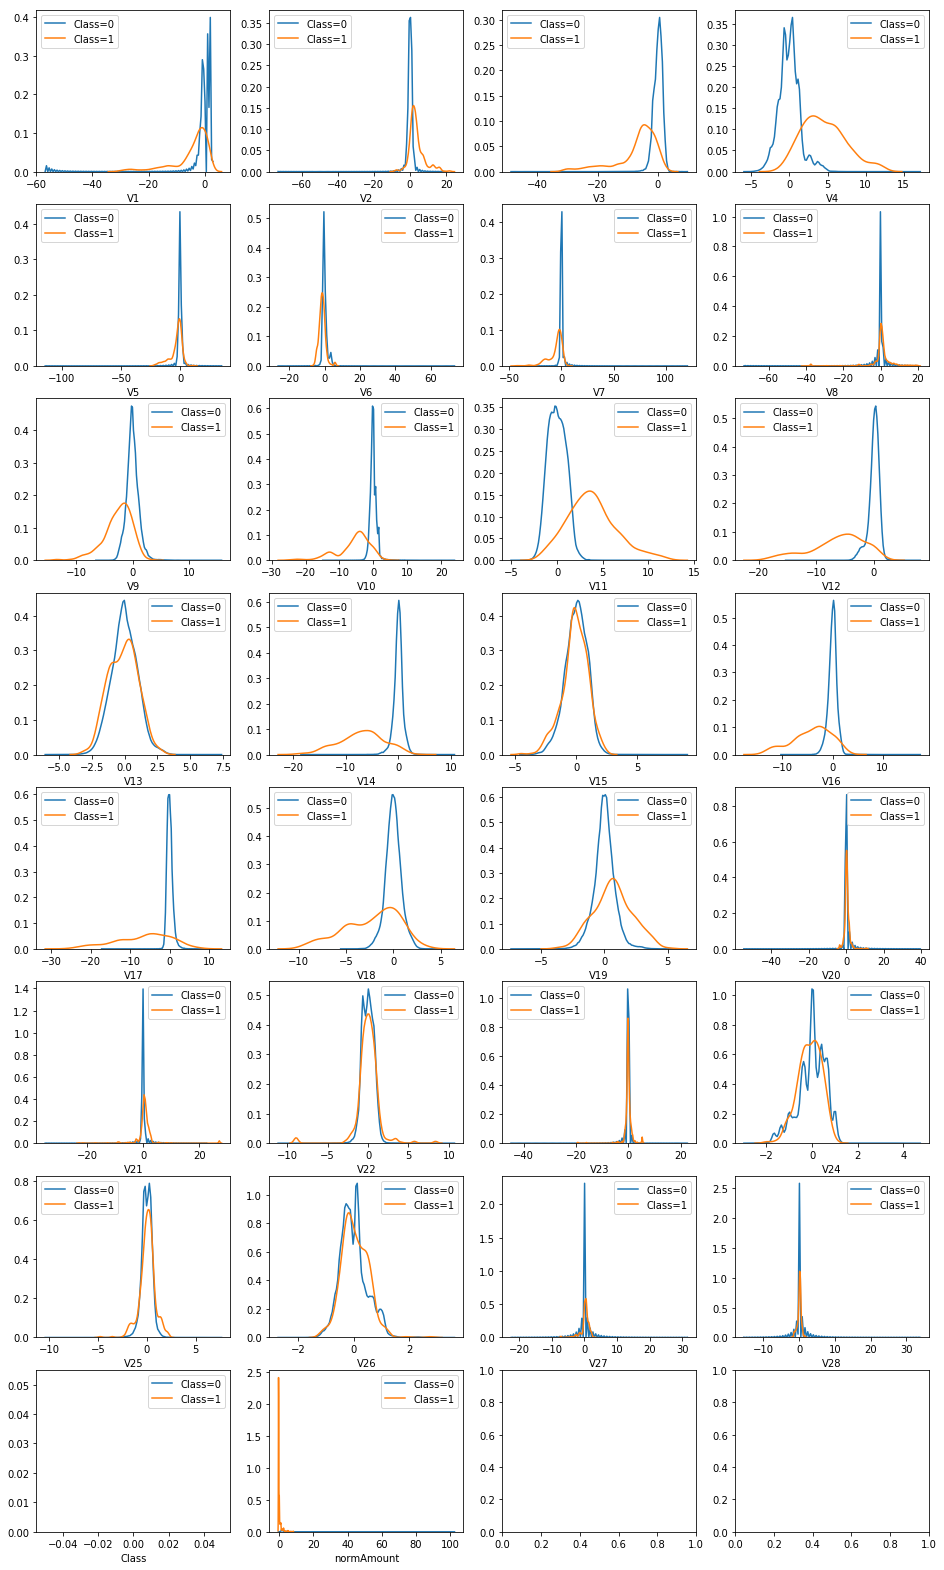

In [23]:
feats = df.columns
d0 = df.loc[df.Class==0,:]
d1 = df.loc[df.Class==1,:]
fig,ax = plt.subplots(8,4,figsize=(16,28))
i = 0
for feat in feats:
    i+=1
    plt.subplot(8,4,i)
    sns.kdeplot(d0[feat],label='Class=0')
    sns.kdeplot(d1[feat],label='Class=1')
    plt.xlabel(feat)

In [24]:
feats = ['V5','V6','V7','V8','V13','V15','V20','V21','V22','V23','V25','V26','V27','V28','normAmount']
X = df.loc[:,feats]
y = df.loc[:,'Class']
from sklearn.ensemble import RandomForestClassifier

In [25]:
clf = RandomForestClassifier(n_jobs=4, 
                             random_state=2018,
                             criterion='entropy',
                             n_estimators=100,
                             verbose=False)

In [26]:
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=2018, shuffle=True )
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=2018, shuffle=True )
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape

((182276, 15), (182276,), (45569, 15), (45569,), (56962, 15), (56962,))

In [27]:
X_train.head()

,V5,V6,V7,V8,V13,V15,V20,V21,V22,V23,V25,V26,V27,V28,normAmount
46038,0.116019,1.800484,0.665996,0.010833,-0.653740,-2.422838,-0.096093,-0.452395,-0.573578,-0.246387,-0.011584,-0.591272,-0.423901,-0.469630,-0.003157
257265,0.211771,0.332727,0.397083,0.194546,0.091831,-1.074204,0.098790,0.131239,0.578832,-0.460271,0.976243,0.873924,-0.083675,-0.037260,-0.133535
282877,-0.025731,-1.138582,-0.206301,-1.061977,1.018141,0.491325,-0.345580,1.867943,0.514204,0.125027,-0.160797,-0.132015,0.180818,0.142101,-0.343434
226150,1.469254,-0.068542,0.508288,-0.076486,-1.046926,-0.854274,-0.206726,-0.055396,-0.057849,-0.132486,0.552893,-0.475008,-0.014708,-0.041982,-0.263472
278800,0.573995,-0.626490,0.578274,-0.248337,-0.552408,-1.159544,-0.201929,0.105351,0.379365,-0.092963,0.445427,-0.490657,-0.029533,-0.067947,-0.131376


In [28]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [29]:
y_pred = clf.predict(X_valid)

In [30]:
confusion_matrix(y_pred=y_pred,y_true=y_valid)

array([[45465,     2],
       [   56,    46]])

In [31]:
pred_test = clf.predict(X_test)

In [32]:
confusion_matrix(y_pred=pred_test,y_true=y_test)

array([[56859,     3],
       [   58,    42]])

In [33]:
#Using semi-supervised learning:

In [34]:
non_fraud = df[df['Class']==0].sample(1000)
fraud = df[df['Class']==1]


In [35]:
df.sample()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
20212,1.075088,-0.016235,0.234308,1.235581,-0.02589,0.329368,-0.04093,0.182886,0.153869,0.048156,0.75133,0.74469,-0.841253,0.387983,-0.690232,-0.393836,-0.066117,-0.283703,0.038808,-0.139523,-0.057871,-0.079845,-0.138398,-0.304465,0.640435,-0.311421,0.024334,0.007307,0,-0.176034


In [36]:
##to be continued